<a href="https://colab.research.google.com/github/maidacundo/fire-segmentation-deep-learning/blob/main/FireSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data

https://github.com/AlirezaShamsoshoara/Fire-Detection-UAV-Aerial-Image-Classification-Segmentation-UnmannedAerialVehicle

In [1]:
is_colab = True

if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import random
import torch

def fix_random(seed: int) -> None:

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True 

In [3]:
RANDOM_STATE = 42
fix_random(RANDOM_STATE)

In [8]:
!unzip /content/drive/MyDrive/fire-segmentation/images.zip -d /content
!unzip /content/drive/MyDrive/fire-segmentation/masks.zip -d /content

Archive:  /content/drive/MyDrive/fire-segmentation/images.zip
   creating: /content/Images/
  inflating: /content/Images/image_1.jpg  
  inflating: /content/Images/image_3.jpg  
  inflating: /content/Images/image_6.jpg  
  inflating: /content/Images/image_7.jpg  
  inflating: /content/Images/image_9.jpg  
  inflating: /content/Images/image_11.jpg  
  inflating: /content/Images/image_22.jpg  
  inflating: /content/Images/image_29.jpg  
  inflating: /content/Images/image_44.jpg  
  inflating: /content/Images/image_46.jpg  
  inflating: /content/Images/image_51.jpg  
  inflating: /content/Images/image_68.jpg  
  inflating: /content/Images/image_53.jpg  
  inflating: /content/Images/image_57.jpg  
  inflating: /content/Images/image_67.jpg  
  inflating: /content/Images/image_89.jpg  
  inflating: /content/Images/image_72.jpg  
  inflating: /content/Images/image_90.jpg  
  inflating: /content/Images/image_86.jpg  
  inflating: /content/Images/image_94.jpg  
  inflating: /content/Images/imag

In [4]:
import numpy as np

In [5]:
IMAGE_RESIZE = (512, 512)

In [6]:
import cv2
import os
from zipfile import ZipFile

def load_images_from_zip(zip_file, is_mask, resize_shape=(512, 512)):
    images = []
    folder = 'Masks/' if is_mask else 'Images/'
    i = 0
    with ZipFile(zip_file) as zf:
        for base, dirs, files in os.walk(folder):
            sorted_files = sorted(files, key=lambda x: int(x.split('_')[1].replace('.jpg', '').replace('.png', '')))
            for filename in sorted_files:
                data = zf.read(base + filename)
                if is_mask:
                    img = cv2.imdecode(np.frombuffer(data, np.uint8), cv2.IMREAD_GRAYSCALE)
                else:
                    img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)

                if img is not None:
                    img = cv2.resize(img, resize_shape, interpolation = cv2.INTER_AREA)
                    images.append(img)
                i+=1
                #if i == 100:
                    #break
        
    return np.array(images)

In [7]:
images = load_images_from_zip('/content/drive/MyDrive/fire-segmentation/images.zip', is_mask=False)

In [9]:
masks = load_images_from_zip('/content/drive/MyDrive/fire-segmentation/masks.zip', is_mask=True)

In [ ]:
assert len(images) == len(masks)

In [9]:
import cv2
import os

def load_images_from_folder(folder, is_mask, resize_shape=(512, 512)):
    images = []
    i = 0
    for filename in sorted(os.listdir(folder)):
        if is_mask:
            img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(folder,filename))

        if img is not None:
            img = cv2.resize(img, resize_shape, interpolation = cv2.INTER_AREA)
            images.append(img)
        i+=1
        # if i == 100:
            # break
        
    return np.array(images)

In [ ]:
images = load_images_from_folder('/content/Images', is_mask=False)
masks = load_images_from_folder('/content/Masks', is_mask=True)

In [10]:
def get_highlighted_roi_by_mask(image: np.ndarray, mask: np.ndarray, highlight_channel: str = 'green') -> np.ndarray:
    """
    Function that highlights a Region of Interest provided by a mask over an image with a given BGR colour.
    Parameters
    ----------
    image: ndarray
        Image on which the mask is highlighted
    mask: ndarray
        Mask illustrating the Region of Interest to highlight over the mage
    highlight_channel: str, optional
        Colour of the highlighted mask: 'blue'; 'green' or 'red' (default: 'green')
    Returns
    -------
    highlighted_roi: ndarray
        Highlighted Region of Interest over the input image
    """
    channel_map = {'blue': 0, 'green': 1, 'red': 2}
    # Turn img into BGR image if img is a Grayscale image
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # Turn mask into BGR image if img is a BGR image
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the selected one at 0
    mask[:, :, [i for i in range(3) if i != channel_map[highlight_channel]]] = 0
    mask[mask == 1] = 255
    # Highlight the unmasked ROI
    return cv2.addWeighted(mask, 0.9, image, 1, 0)

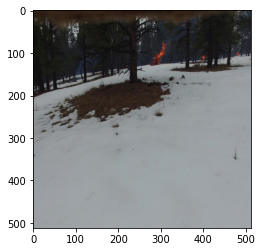

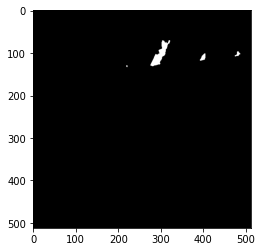

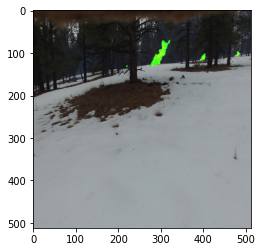

In [11]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(masks[0], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.imshow(cv2.cvtColor(get_highlighted_roi_by_mask(images[0], masks[0]), cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(images, masks, test_size=0.15, shuffle=True, random_state=RANDOM_STATE)

In [13]:
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.15, shuffle=True, random_state=RANDOM_STATE)

In [14]:
print(f'Train shapes: {X_train.shape}, {y_train.shape}')
print(f'Val shapes: {X_val.shape}, {y_val.shape}')
print(f'Test shapes: {X_test.shape}, {y_test.shape}')

Train shapes: (1446, 512, 512, 3), (1446, 512, 512)
Val shapes: (256, 512, 512, 3), (256, 512, 512)
Test shapes: (301, 512, 512, 3), (301, 512, 512)


## Model

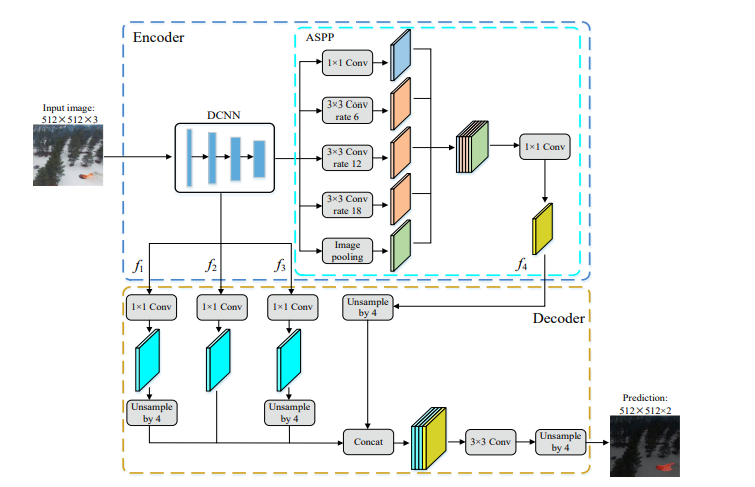

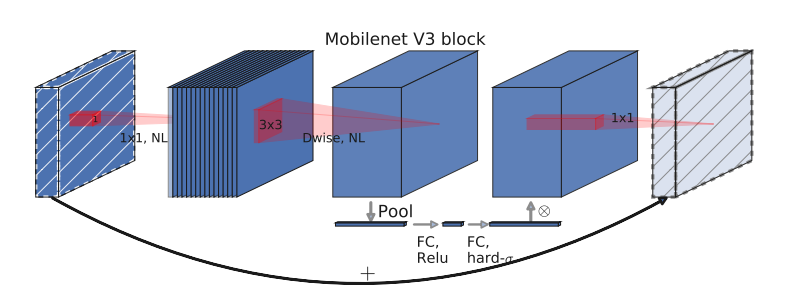

In [15]:
import torch
from torch import nn 
import torch.nn.functional as F

In [16]:
class MobileBottleNeck(nn.Module):

    def __init__(self, in_channels, expansion, out_channels, kernel_size, activation_layer, use_squeeze_excitation, stride=1, padding=1):
        super(MobileBottleNeck, self).__init__()

        self.use_skip_conn = stride == 1 and in_channels == out_channels
        self.use_squeeze_excitation = use_squeeze_excitation

        self.standard_conv = nn.Sequential(
            nn.Conv2d(in_channels, expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(expansion),
            activation_layer(),
        )


        # DEPTH-WISE CONV


        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(expansion, expansion, kernel_size=kernel_size, stride=stride, 
                                        groups=expansion, padding=padding, bias=False),
            nn.BatchNorm2d(expansion),
        )

        # SQUEEZE-AND-EXCITATION

        self.squeeze_excitation = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Conv2d(expansion, in_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, expansion, kernel_size=1),
            nn.Hardswish(),
        )


        # POINTWISE CONVOLUTION
        self.pointwise_conv = nn.Sequential( 
            nn.Conv2d(expansion, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            #activation_layer(),
        )

    def forward(self, x):
        residual = x.clone()

        # STANDARD CONV
        out = self.standard_conv(x)

        # DEPTH-WISE CONV
        depth_wise_out = self.depthwise_conv(out)
        if self.use_squeeze_excitation:
            # SQUEEZE-AND-EXCITATION
            out = self.squeeze_excitation(depth_wise_out)

            out = out * depth_wise_out    
        
        else:
            out = depth_wise_out

            
        # POINTWISE CONVOLUTION
        out = self.pointwise_conv(out)

        if self.use_skip_conn:
            out = out + residual

        return out

In [17]:
class DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        in_channels = 3

        # INPUT LAYERS
        self.input_convolution = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.Hardswish(),
        )

        # BOTTLENECKS 
        self.bottleneck1 =  nn.Sequential(
            MobileBottleNeck(16, 16, 16, 3, nn.ReLU, False, stride=1),
        )

        self.bottleneck2 =  nn.Sequential(
            MobileBottleNeck(16, 64, 24, 3, nn.ReLU, False, stride=2, padding=1),
            MobileBottleNeck(24, 72, 24, 3, nn.ReLU, False, stride=1),
        )

        self.bottleneck3 =  nn.Sequential(
            MobileBottleNeck(24, 72, 40, 5, nn.ReLU, True, stride=2, padding=2),
            MobileBottleNeck(40, 120, 40, 5, nn.ReLU, True, stride=1, padding=2),
            MobileBottleNeck(40, 120, 40, 5, nn.ReLU, True, stride=1, padding=2),
        )    
        self.bottleneck4 =  nn.Sequential(        
            MobileBottleNeck(40, 240, 80, 3, nn.Hardswish, False, stride=2),
            MobileBottleNeck(80, 200, 80, 3, nn.Hardswish, False, stride=1),
            MobileBottleNeck(80, 184, 80, 3, nn.Hardswish, False, stride=1),
            MobileBottleNeck(80, 184, 80, 3, nn.Hardswish, False, stride=1),
            MobileBottleNeck(80, 480, 112, 3, nn.Hardswish, True, stride=1),
            MobileBottleNeck(112, 672, 160, 3, nn.Hardswish, True, stride=1),
            MobileBottleNeck(160, 672, 160, 5, nn.Hardswish, True, stride=1, padding=2),
            MobileBottleNeck(160, 960, 160, 5, nn.Hardswish, True, stride=1, padding=2),
            MobileBottleNeck(160, 960, 160, 5, nn.Hardswish, True, stride=1, padding=2),
        )

    def forward(self, x):
        out = self.input_convolution(x)
        f1 = self.bottleneck1(out)
        f2 = self.bottleneck2(f1)
        f3 = self.bottleneck3(f2)
        out = self.bottleneck4(f3)
        
        return f1, f2, f3, out

In [18]:
class ASPP(nn.Module):
    def __init__(self):
        super().__init__()

        in_channels = 160
        out_channels = 256

        # STANDARD CONVOLUTION LAYER

        self.standard_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        # ATROUS CONVOLUTION LAYERS

        self.atrous_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, bias=False, dilation=6, padding=6),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.atrous_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, bias=False, dilation=12, padding=12),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.atrous_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, bias=False, dilation=18, padding=18),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        # IMAGE POOLING
        self.image_pooling = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.final_conv = nn.Sequential(
            nn.Conv2d(out_channels*5, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

    def forward(self, x):

        out1 = self.standard_conv(x)
        out2 = self.atrous_conv_1(x)
        out3 = self.atrous_conv_2(x)
        out4 = self.atrous_conv_3(x)

        out5 = self.image_pooling(x)
        # replicate spatially the pooling result
        out5 = F.interpolate(out5, size=x.shape[-2:], mode='bilinear', align_corners=False)

        out = torch.cat([out1, out2, out3, out4, out5], dim=1)
        f4 = self.final_conv(out)

        return f4

In [19]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dcnn = DCNN()
        self.aspp = ASPP()

    def forward(self, x):
        f1, f2, f3, out = self.dcnn(x)
        f4 = self.aspp(out)
        return f1, f2, f3, f4 

In [20]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        out_channels = 256
        f2_size = (128, 128)

        self.conv_f1 = nn.Sequential(
            nn.Conv2d(16, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv_f2 = nn.Sequential(
            nn.Conv2d(24, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv_f3 = nn.Sequential(
            nn.Conv2d(40, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.upsample_f1 = nn.Upsample(f2_size, mode='bilinear', align_corners=False)
        self.upsample_f3 = nn.Upsample(f2_size, mode='bilinear', align_corners=False)
        self.upsample_f4 = nn.Upsample(f2_size, mode='bilinear', align_corners=False)

        self.final_conv = nn.Sequential(
            nn.Conv2d(out_channels * 4, 256, kernel_size=3, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 2, kernel_size=1, stride=1),
        )

        self.final_upsample = nn.Upsample((512, 512), mode='bilinear', align_corners=False)

    def forward(self, f1, f2, f3, f4):
        out_f1 = self.conv_f1(f1)
        out_f2 = self.conv_f2(f2)
        out_f3 = self.conv_f3(f3)

        out_f1 = self.upsample_f1(out_f1)
        out_f3 = self.upsample_f3(out_f3)
        out_f4 = self.upsample_f4(f4)

        out = torch.cat([out_f1, out_f2, out_f3, out_f4], dim=1)

        out = self.final_conv(out)
        out = self.final_upsample(out)

        return out

In [21]:
class FireSegmentationModel(nn.Module):
    def __init__(self, device: str):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.to(device)
        
    def forward(self, x: torch.FloatTensor):
        #x = x.permute(0, 3, 1, 2)
        f1, f2, f3, f4 = self.encoder(x)
        out = self.decoder(f1, f2, f3, f4)
        #out = out.permute(0, 2, 3, 1)
        return out
        

In [144]:
model = FireSegmentationModel('cuda')

In [23]:
model

FireSegmentationModel(
  (encoder): Encoder(
    (dcnn): DCNN(
      (input_convolution): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (bottleneck1): Sequential(
        (0): MobileBottleNeck(
          (standard_conv): Sequential(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (depthwise_conv): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (squeeze_excitation): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): C

In [ ]:
# res = model(torch.tensor(images[0:2], device='cuda', dtype=torch.float32).permute(0,3,1,2))

In [ ]:
# res.shape

## Test model DeepLabv3


In [ ]:
class DeepLab(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)

        self.final_conv = nn.Sequential(
            nn.Conv2d(21, 1, kernel_size=1, bias=False),
        )

    def forward(self, x):
        out = self.model(x)['out']
        out = self.final_conv(out)
        return out

In [ ]:
model = DeepLab()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Dataset


In [26]:
from typing import Tuple
from torch.utils.data.dataloader import Dataset, DataLoader, Optional
from torchvision.transforms import  Compose, ToTensor, RandomResizedCrop, RandomAffine, ColorJitter, RandomHorizontalFlip, RandomPerspective

transform_image_and_mask = Compose([
    # RandomResizedCrop(IMAGE_RESIZE, scale=(0.7, 1.)),
    RandomPerspective(distortion_scale=.3),
    RandomHorizontalFlip(),
    RandomAffine(degrees=(-45, 45), translate=(0.1, 0.1), scale=(0.8, 1.2))
    ])

transform_image = ColorJitter(brightness=.4, hue=.05)

class FireDetectionDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, 
                 transform_image_and_mask: Optional[Compose] = None,
                 transform_image: Optional[ColorJitter] = None) -> None:
        super().__init__()
        assert x.shape[:-1] == y.shape
        self.x = x
        self.y = y
        self.len = x.shape[0]
        self.transform_image_and_mask = transform_image_and_mask
        self.transform_image = transform_image
        self.to_tensor = ToTensor()
    
    def __getitem__(self, index: int) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        x = self.x[index]
        y = self.y[index]

        x = self.to_tensor(x)
        y[y==1] = 255
        y = self.to_tensor(y)

        if self.transform_image_and_mask is not None:
            y = y.expand_as(x)
            x_y = torch.cat([x.unsqueeze(0), y.unsqueeze(0)], dim=0)
            x_y = self.transform_image_and_mask(x_y)
            x, y = x_y[0], x_y[1]
            y = y[:1]
        if self.transform_image is not None:
            x = self.transform_image(x)

        y_b = (~y.bool()).float()
        y = torch.cat([y_b, y], dim=0)
        return x, y
    
    def __len__(self) -> int:
        return self.len
    


In [ ]:
"""x, y = images[50], masks[50]

x = ToTensor()(x)
y[y==1] = 255
y = ToTensor()(y)

y = y.expand_as(x)

x_y = torch.cat([x.unsqueeze(0), y.unsqueeze(0)], dim=0)

x_y = transform_image_and_mask(x_y)
x, y = x_y[0], x_y[1]

y = y[:1]

# y = y.bool().float()

x = transform_image(x)
#print('x', x)
#print('y', y)

plt.imshow(cv2.cvtColor(x.permute(1,2,0).cpu().numpy(), cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(y.permute(1,2,0).cpu().numpy()[..., 0], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.imshow(cv2.cvtColor(images[50], cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(masks[50], cmap='gray', vmin=0., vmax=1.)
plt.show()""";

In [27]:
TRAIN_BATCH_SIZE = 2
EVAL_BATCH_SIZE = 4

train_loader = DataLoader(FireDetectionDataset(X_train, y_train, transform_image_and_mask, transform_image),
                          batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

val_loader = DataLoader(FireDetectionDataset(X_val, y_val),
                          batch_size=EVAL_BATCH_SIZE, shuffle=False)

test_loader = DataLoader(FireDetectionDataset(X_test, y_test),
                          batch_size=EVAL_BATCH_SIZE, shuffle=False, drop_last=True)

## Loss, Optimizer, Scheduler

In [28]:
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR

#optimizer = SGD(model.parameters(), lr=1e-4, nesterov=True, weight_decay=0.0001, momentum=.9)
optimizer = Adam(model.parameters(), lr=1e-3)#, nesterov=True, weight_decay=0.0001, momentum=.9)
lr_scheduler = StepLR(optimizer, gamma=.94, step_size=2)

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch 

class FocalLoss(nn.Module):
    def __init__(self, gamma=.5):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        pt = F.binary_cross_entropy_with_logits(
            logits, targets, reduction='none')
        #pt = torch.exp(-ce_loss)
        focal_loss = - (1 - pt)**self.gamma * torch.log(pt)
        return focal_loss.mean()

In [51]:
class FocalLossDeepLab(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        if focal_loss.mean().isnan():
            print(ce_loss)
        return focal_loss.mean()


In [ ]:
"""import torch.nn as nn
import torch

class SoftDiceLoss(nn.Module):
    def __init__(self, p=1, smooth=1e-6):
        super().__init__()
        self.p = p
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        # probs = logits
        numer = (probs * targets).sum((-2, -1))
        denor = (probs.pow(self.p).sum((-2, -1)) + targets.pow(self.p).sum((-2, -1)))
        loss = 1 - (2 * numer + self.smooth) / (denor + self.smooth)
        return torch.mean(loss)""";

In [ ]:
"""y_pred = torch.tensor(masks[0:5])#torch.tensor([[0,1],[0,1]])
y_true = torch.tensor(masks[0:5])#torch.tensor([[1,1],[1,1]])
mpa = SoftDiceLoss()
mpa(y_pred, y_true)""";

tensor(0.9870)

In [145]:
mpa = MPA()
mpa(y_pred[0:2], (~y_true.bool()).float())

RuntimeError: ignored

In [122]:
_, y_true = next(iter(train_loader))
_, y_pred = next(iter(test_loader))
miou = MIoU()
miou(y_pred[0:2], (~y_true.bool()).float())

torch.Size([2, 2, 512, 512]) torch.Size([2, 2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])


tensor(0.0080)

In [132]:
class MIoU(nn.Module):
    def __init__(self, threshold=.5, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        self.threshold = threshold

    def forward(self, y_pred, y_true):
        with torch.no_grad():
            y_pred = y_pred.argmax(-3)
            y_true = y_true[:,1].bool()
            intersection = (y_pred & y_true).sum((-2, -1))
            union = (y_pred | y_true).sum((-2, -1))

            iou = (intersection + self.smooth) / (union + self.smooth)
            return torch.mean(iou)

In [131]:
class MPA(nn.Module):
    def __init__(self, threshold=.5, smooth=1e-6):
        super().__init__()
        self.threshold = threshold
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        with torch.no_grad():
            y_pred = y_pred.argmax(-3)
            y_true = y_true[:,1].bool()

            intersection = (y_pred & y_true).sum((-2, -1))
            # count total number of elements per image (pixel count)
            total_pixels = (y_true > 0).sum((-2, -1))
            mpa = (intersection + self.smooth) / (total_pixels + self.smooth)
            return torch.mean(mpa)

## Training Loop

In [146]:
import os
from time import time
from typing import Dict, Optional, Tuple
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

class Checkpoint():
    """Class to handle the checkpoints of a model."""
    def __init__(self, path: str, initial_error: float = float('inf')) -> None:
        """Initialize the checkpoint instance.
        
        Parameters
        ----------
        path : str
            The checkpoint path.
        initial_error : float, optional
            The initial error value, by default inf.
        """
        self.last_error = initial_error

        self.path = path
        os.makedirs(os.path.dirname(self.path), exist_ok=True)

    def save_best(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                  new_error: float) -> None:
        """Possibly save the best model weights and optimizer state 
        in the checkpoint file according to the new value of the metric.
        
        Parameters defined in `kwargs` are also saved in the checkpoints
        as an ndarray. 
        
        Parameters
        ----------
        model : Module
            The model which weights are saved.
        optimizer : Optimizer
            The optimizer which state is saved
        new_error : float
            The new error value which is compared to the best so far.
            The checkpoints are updated solely if the new error is less.
        """
        if new_error < self.last_error:
            checkpoint = {}
            checkpoint['model_state_dict'] = model.state_dict()
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
            checkpoint['best_error'] = new_error

            torch.save(checkpoint, self.path)

        self.last_error = new_error

    def load_best_weights(self, model: nn.Module) -> None:
        """Load the best weights on a model.

        Parameters
        ----------
        model : Module
            The model for which the best weights are loaded.
        """
        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])

def train(
    model: FireSegmentationModel, optimizer: torch.optim.Optimizer,
    lr_scheduler: Optional[object],
    train_dataloader: DataLoader, val_dataloader: DataLoader,
    epochs: int, device: str, checkpoint: Optional[Checkpoint] = None,
    reload_best_weights: bool = True) -> Dict[str, np.ndarray]:
    # Initialize loss functions.
    # criterion = nn.BCEWithLogitsLoss()
    criterion = FocalLossDeepLab()
    mpa_metric = MPA()
    miou_metric = MIoU()

    # Initialize histories.
    metrics = ['train_loss', 'train_mpa', 'train_miou', 'val_loss', 'val_mpa',
               'val_miou']
    history = { m: [] for m in metrics }

    # Set model in training mode.
    model.train()

    # Iterate across the epochs.
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Remove unused tensors from gpu memory.
        torch.cuda.empty_cache()

        # Initialize running loss and errors.
        running_train_loss = 0.
        running_train_mpa = 0.
        running_train_miou = 0.

        start_time = time()

        for batch_idx, data in enumerate(train_dataloader, 0):
            # Increment the number of batch steps.
            batch_steps = batch_idx + 1

            # Get the data.
            x, y = data
            x = x.to(device=device)
            y = y.to(device=device)

            # Compute model predictions.
            y_pred = model(x)
            

            # Compute the loss on the scaled results and ground truth.
            loss = criterion(y_pred, y)
            running_train_loss += loss.item()

            # Zero the gradients.
            optimizer.zero_grad()

            # Compute errors and update running errors.
            # TODO: add mpa miou
            mpa = mpa_metric(y_pred, y)
            miou = miou_metric(y_pred, y)

            running_train_mpa += mpa.item()
            running_train_miou += miou.item()

            # Use the loss function for backpropagation.
            loss.backward()

            # Update the weights.
            optimizer.step()

            epoch_time = time() - start_time
            batch_time = epoch_time / batch_steps

            print(
                f'[{batch_steps}/{len(train_dataloader)}] -',
                f'{epoch_time:.0f}s {batch_time * 1e3:.0f}ms/step -',

                f'train {{ loss: {running_train_loss / batch_steps:.3g} -',
                f'MPA: {running_train_mpa * 100. / batch_steps:.3g}% -',
                f'MiOU: {running_train_miou * 100. / batch_steps:.3g}% }} -',

                f'lr: {optimizer.param_groups[0]["lr"]:.3g}',
                '             ' if batch_steps < len(train_dataloader) else '',
                )#end='\r')

        # Set the model in evaluation mode.
        model.eval()

        '''train_loss = running_train_loss / len(train_dataloader)
        train_mae = running_train_mae / len(train_dataloader)
        train_rmse = running_train_rmse / len(train_dataloader)
        train_smape = running_train_mape / len(train_dataloader)

        history['train_loss'].append(train_loss)
        history['train_mae'].append(train_mae)
        history['train_rmse'].append(train_rmse)
        history['train_smape'].append(train_smape)

        val_results = validate(model, val_dataloader, mae_function, 
                               rmse_function, mape_function, scaler, device)
        val_loss, val_mae, val_rmse, val_smape = val_results

        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_rmse'].append(val_rmse)
        history['val_smape'].append(val_smape)'''

        if checkpoint is not None:
            pass
            #err_sum = val_mae + val_rmse + val_smape
            #checkpoint.save_best(model, optimizer, err_sum)

        '''print(
            f'[{len(train_dataloader)}/{len(train_dataloader)}] -',
            f'{epoch_time:.0f}s -',

            f'train: {{ loss: {train_loss:.3g} -',
            f'MAE: {train_mae:.3g} -',
            f'RMSE: {train_rmse:.3g} -',
            f'sMAPE: {train_smape * 100.:.3g}% }} -',

            f'val: {{ loss: {val_loss:.3g} -',
            f'MAE: {val_mae:.3g} -',
            f'RMSE: {val_rmse:.3g} -',
            f'sMAPE: {val_smape * 100.:.3g}% }} -',

            f'lr: {optimizer.param_groups[0]["lr"]:.3g} -',
            f'weight decay: {optimizer.param_groups[0]["weight_decay"]}')'''

        lr_scheduler.step()

        # Set model in training mode.
        model.train()

    if checkpoint is not None and reload_best_weights:
        checkpoint.load_best_weights(model)

    model.eval()

    # Remove unused tensors from gpu memory.
    torch.cuda.empty_cache()

    # Turn histories in ndarrays.
    for k, v in history.items():
        history[k] = np.array(v)

    return history

def validate(
    model: nn.Module, val_dataloader: DataLoader, mae_function: nn.Module,
    rmse_function: nn.Module, mape_function: nn.Module, scaler: object, device: str, 
    n_timestamps_to_predict: Optional[int] = None
    ) -> Tuple[float, float, float, float]:
    torch.cuda.empty_cache()

    running_val_loss = 0.
    running_val_mae = 0.
    running_val_rmse = 0.
    running_val_smape = 0.

    with torch.no_grad():
        for _, data in enumerate(val_dataloader, 0):
            # Get the data.
            x, y = data
            x = scaler.scale(x)
            x = x.type(torch.float32).to(device=device)
            y = y.type(torch.float32).to(device=device)

            # Compute output.
            y_pred = model(x)
            print(y_pred)

            if n_timestamps_to_predict is not None:
                y_pred = y_pred[:, : n_timestamps_to_predict]
                y = y[:, : n_timestamps_to_predict]

            loss = mae_function(y_pred, scaler.scale(y))
            running_val_loss += loss.item()

            y_pred = scaler.un_scale(y_pred)

            # Loss
            mae = mae_function(y_pred, y)
            rmse = rmse_function(y_pred, y)
            mape = mape_function(y_pred, y)
            running_val_mae += mae.item()
            running_val_rmse += rmse.item()
            running_val_smape += mape.item()

    torch.cuda.empty_cache()

    val_loss = running_val_loss / len(val_dataloader)
    val_mae = running_val_mae / len(val_dataloader)
    val_rmse = running_val_rmse / len(val_dataloader)
    val_smape = running_val_smape / len(val_dataloader)

    return val_loss, val_mae, val_rmse, val_smape


In [147]:
EPOCHS = 30

train(model.to('cuda'), optimizer, lr_scheduler, train_loader, val_loader, 30, 'cuda', None, False)

Epoch 1/30
[1/723] - 0s 277ms/step - train { loss: 0.0589 - MPA: 80.5% - MiOU: 0.949% } - lr: 0.001              
[2/723] - 1s 256ms/step - train { loss: 0.0586 - MPA: 81.9% - MiOU: 0.914% } - lr: 0.001              
[3/723] - 1s 249ms/step - train { loss: 0.0589 - MPA: 77.9% - MiOU: 0.839% } - lr: 0.001              
[4/723] - 1s 244ms/step - train { loss: 0.0591 - MPA: 82.2% - MiOU: 0.702% } - lr: 0.001              
[5/723] - 1s 244ms/step - train { loss: 0.0589 - MPA: 85.3% - MiOU: 0.66% } - lr: 0.001              
[6/723] - 1s 240ms/step - train { loss: 0.059 - MPA: 84.3% - MiOU: 0.781% } - lr: 0.001              
[7/723] - 2s 241ms/step - train { loss: 0.0587 - MPA: 84.3% - MiOU: 0.76% } - lr: 0.001              
[8/723] - 2s 241ms/step - train { loss: 0.0587 - MPA: 85.2% - MiOU: 0.755% } - lr: 0.001              
[9/723] - 2s 243ms/step - train { loss: 0.0586 - MPA: 86% - MiOU: 0.701% } - lr: 0.001              
[10/723] - 2s 246ms/step - train { loss: 0.0586 - MPA: 85.3% - MiOU

KeyboardInterrupt: ignored

In [140]:
x, y_true = next(iter(test_loader))

y_pred = model(x.to('cuda'))

In [88]:
miou = MPA()
miou(y_true, y_true)

tensor(1.)

In [89]:
miou = MIoU()
miou(y_true, y_true)

tensor(1.)

In [141]:
y_true = y_true.permute(0, 2, 3, 1)[...,1]
y_true.shape

torch.Size([4, 512, 512])

In [142]:
y_pred = y_pred.argmax(-3)
y_pred.shape

torch.Size([4, 512, 512])

In [92]:
y_pred[0].cpu().numpy().shape

(512, 512)

In [93]:
x = x.permute(0, 2, 3, 1)

RuntimeError: ignored

y true


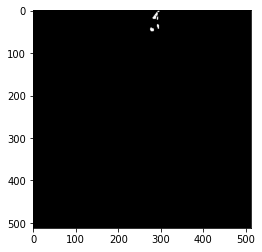

y pred


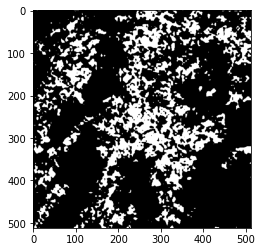

y true


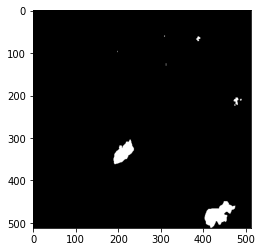

y pred


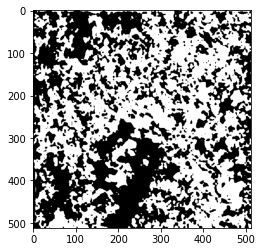

y true


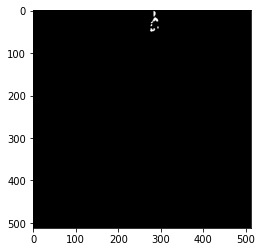

y pred


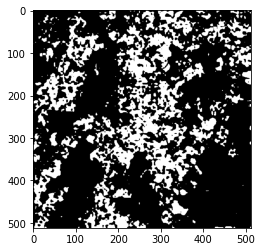

y true


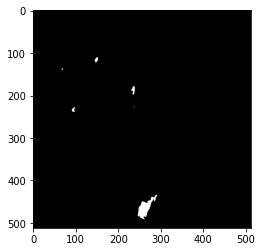

y pred


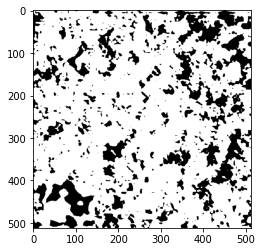

In [143]:
for i, (x, t, p) in enumerate(zip(x, y_true, y_pred)):
    #print(x.shape)
    #plt.imshow(cv2.cvtColor(x.cpu().numpy(), cv2.COLOR_BGR2RGB))
    #plt.show()
    print('y true')
    plt.imshow(y_true[i].cpu().numpy(), cmap='gray', vmin=0., vmax=1.)
    plt.show()
    print('y pred')
    plt.imshow(y_pred[i].cpu().numpy(), cmap='gray', vmin=0., vmax=1.)
    plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/fire-segmentation/model.ckpt')

In [ ]:
torch.cuda.empty_cache()
del model

NameError: ignored

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()